### Exploratory Data Analysis

- CountVectorizer
- Visuals
- Tfidf
- Visuals

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import time
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

#### Import Data

In [2]:
df_final = pd.read_csv('../data/df_final.csv')

#### Instantiate CountVectorizer

In [30]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5, max_df=1.0)

In [31]:
cvec_mat = cvec.fit_transform(df_final['title'])

In [32]:
len(cvec.get_feature_names())

1083

In [33]:
cvec_df = pd.DataFrame(cvec_mat.toarray(), columns=cvec.get_feature_names())

In [34]:
cvec_df.head()

,000,10,100,11,12,13,14,15,16,17,...,working,world,worlds,year,year old,years,years ago,yesterday,zone,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
cvec_df['subreddit'] = df_final['subreddit'].values

In [36]:
cvec_spacex_mean_df = cvec_df.groupby('subreddit').mean().T.sort_values('spacex', ascending=False).head()
cvec_spacex_mean_df

subreddit,nasa,spacex
spacex,0.016992,0.434295
falcon,0.004248,0.264423
launch,0.062872,0.209936
heavy,0.009346,0.094551
falcon heavy,0.002549,0.089744


In [37]:
cvec_spacex_mean_df[['spacex']].T.values[0]

array([0.43429487, 0.26442308, 0.2099359 , 0.09455128, 0.08974359])

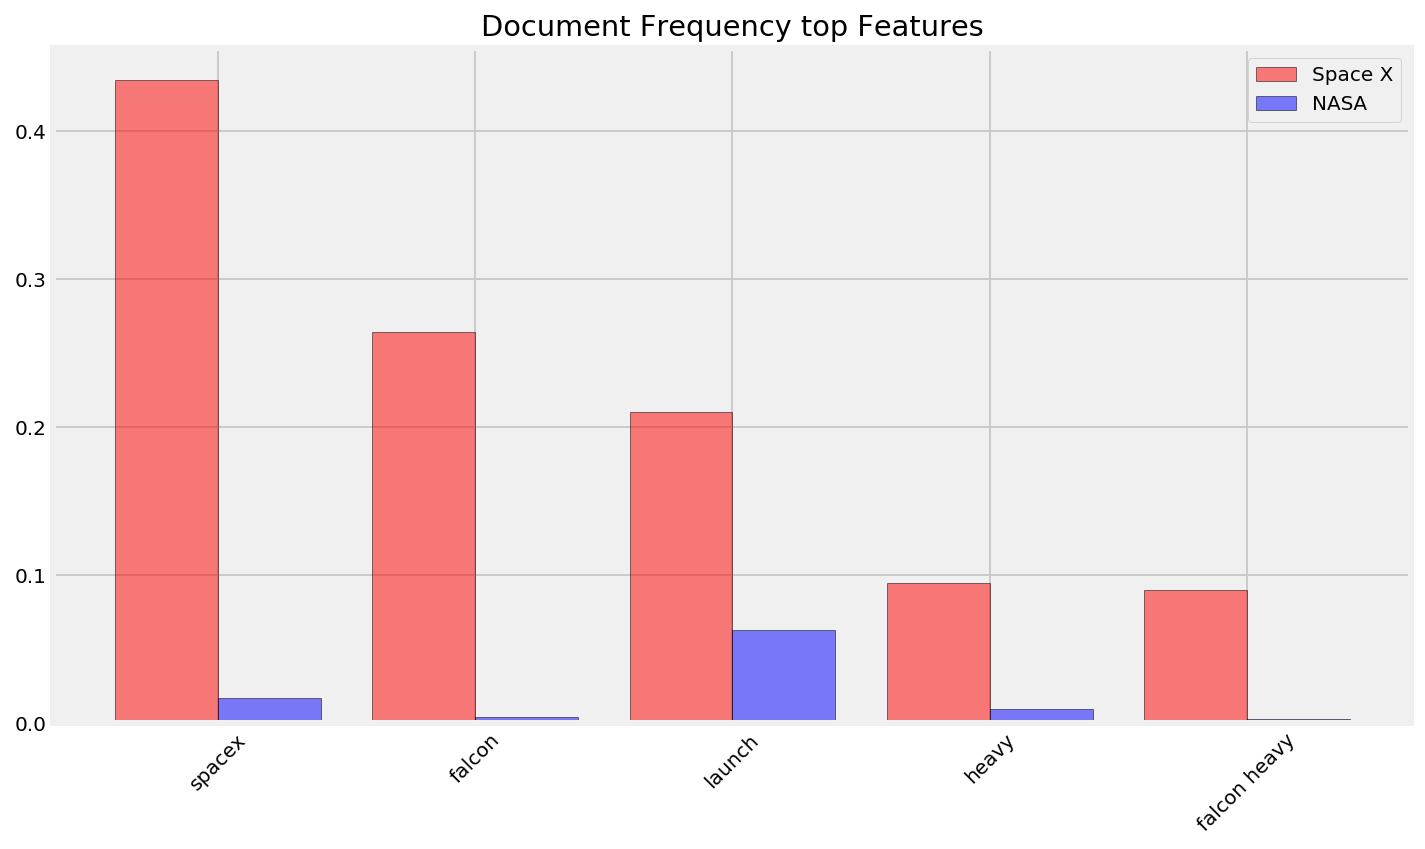

In [38]:
plt.figure(figsize=(10,6))
locs, labels = plt.xticks(fontsize=10)
plt.setp(labels, rotation=45)
plt.title('Document Frequency top Features')
plt.bar(cvec_spacex_mean_df.index, cvec_spacex_mean_df[['spacex']].T.values[0], alpha=0.5, align='edge', width=-.4, ec='k', color='red')
plt.bar(cvec_spacex_mean_df.index, cvec_spacex_mean_df[['nasa']].T.values[0], alpha=0.5, align='edge', width=.4, ec='k', color='blue')
plt.legend(['Space X', 'NASA'])
plt.tight_layout();

In [39]:
cvec_nasa_mean_df = cvec_df.groupby('subreddit').mean().T.sort_values('nasa', ascending=False).head()
cvec_nasa_mean_df

subreddit,nasa,spacex
nasa,0.355990,0.073718
space,0.172472,0.086538
mars,0.084112,0.042468
launch,0.062872,0.209936
moon,0.062022,0.011218


In [40]:
cvec_nasa_mean_df[['nasa']].T.values[0]

array([0.3559898 , 0.17247239, 0.08411215, 0.06287171, 0.06202209])

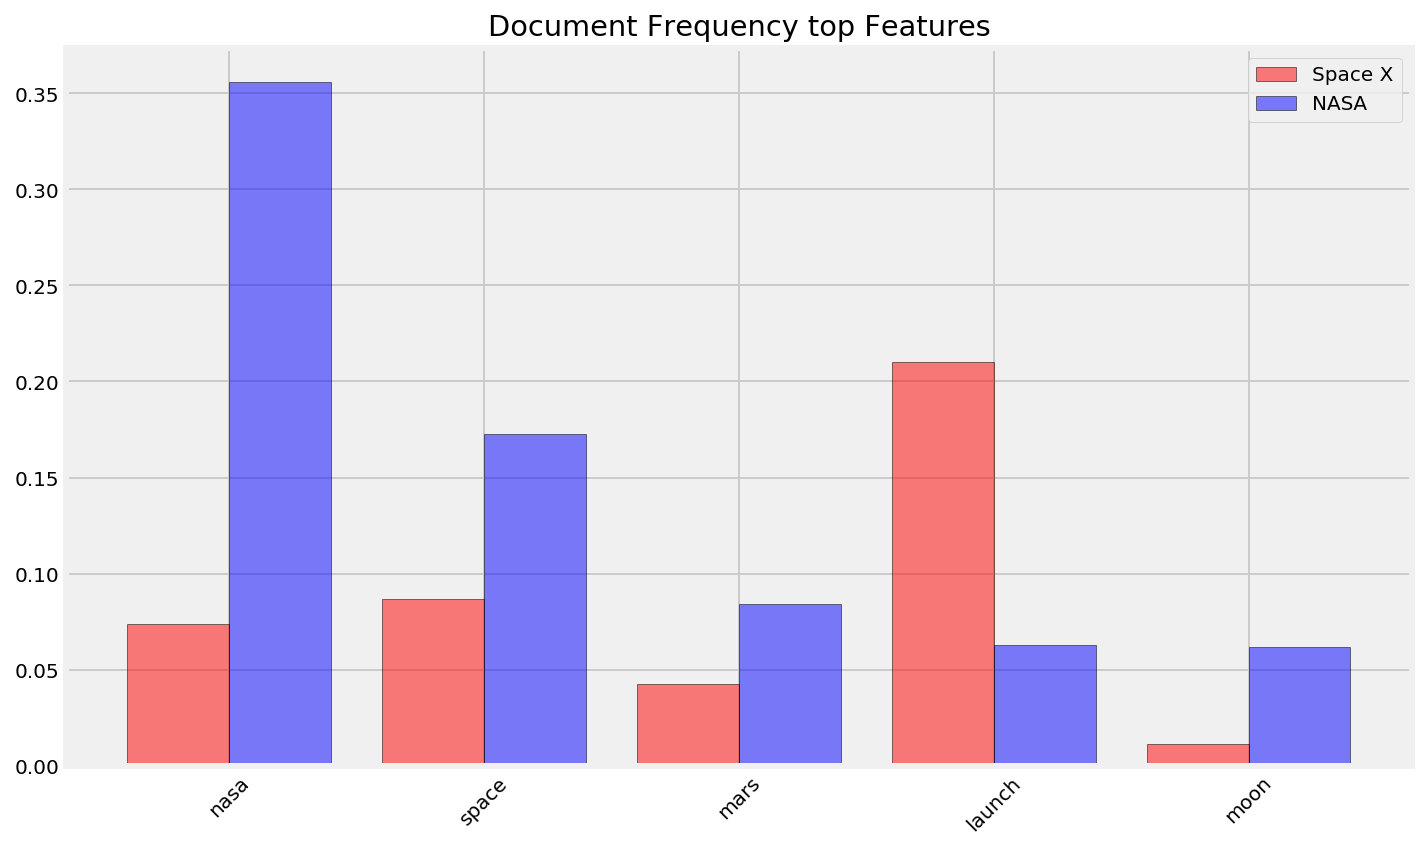

In [41]:
plt.figure(figsize=(10,6))
locs, labels = plt.xticks(fontsize=10)
plt.setp(labels, rotation=45)
plt.title('Document Frequency top Features')
plt.bar(cvec_nasa_mean_df.index, cvec_nasa_mean_df[['spacex']].T.values[0], alpha=0.5, align='edge', width=-.4, ec='k', color='red')
plt.bar(cvec_nasa_mean_df.index, cvec_nasa_mean_df[['nasa']].T.values[0], alpha=0.5, align='edge', width=.4, ec='k', color='blue')
plt.legend(['Space X', 'NASA'])
plt.tight_layout();

#### Instantiate TFIDF

In [50]:
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.01)

In [51]:
tvec_mat = tvec.fit_transform(df_final['title'])

In [52]:
tvec_df = pd.DataFrame(tvec_mat.toarray(), columns=tvec.get_feature_names())

In [53]:
tvec_df.head()

,11,12,15,2018,39a,40,air,air force,amp,apollo,...,time,today,twitter,updates,vab,vehicle,video,view,year,years
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.868560,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.382751,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.424249,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.560477,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
tvec_df['subreddit'] = df_final['subreddit'].values

In [56]:
tvec_spacex_mean_df = tvec_df.groupby('subreddit').mean().T.sort_values('spacex', ascending=False).head()
tvec_spacex_mean_df

subreddit,nasa,spacex
spacex,0.006652,0.175495
falcon,0.001113,0.094979
launch,0.024947,0.074744
dragon,0.003127,0.040030
heavy,0.003006,0.040014


In [58]:
tvec_spacex_mean_df[['spacex']].T.values[0]

array([0.17549476, 0.09497858, 0.07474436, 0.04003001, 0.04001412])

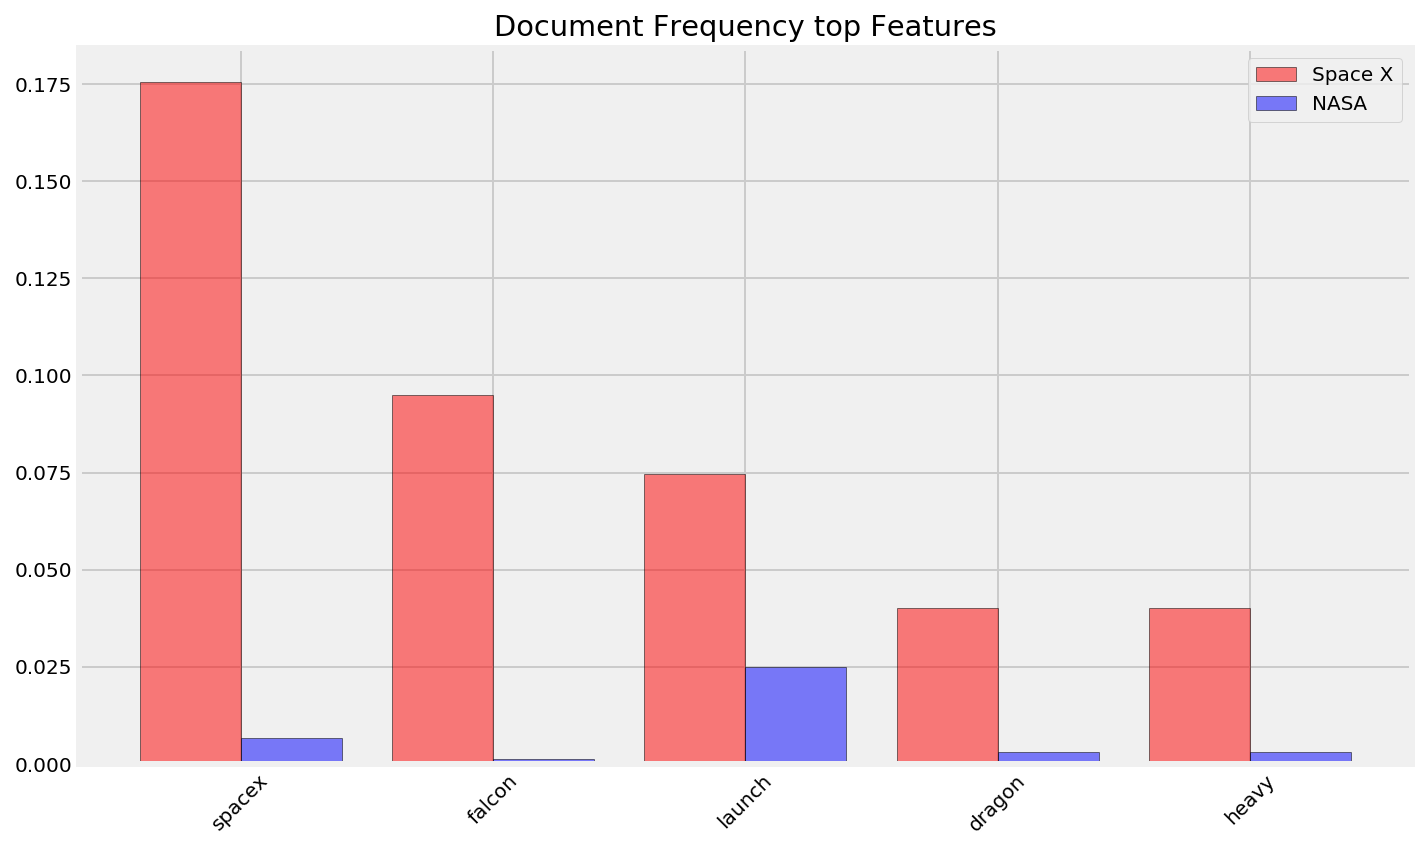

In [59]:
plt.figure(figsize=(10,6))
locs, labels = plt.xticks(fontsize=10)
plt.setp(labels, rotation=45)
plt.title('Document Frequency top Features')
plt.bar(tvec_spacex_mean_df.index, tvec_spacex_mean_df[['spacex']].T.values[0], alpha=0.5, align='edge', width=-.4, ec='k', color='red')
plt.bar(tvec_spacex_mean_df.index, tvec_spacex_mean_df[['nasa']].T.values[0], alpha=0.5, align='edge', width=.4, ec='k', color='blue')
plt.legend(['Space X', 'NASA'])
plt.tight_layout();

In [60]:
tvec_nasa_mean_df = tvec_df.groupby('subreddit').mean().T.sort_values('nasa', ascending=False).head()
tvec_nasa_mean_df

subreddit,nasa,spacex
nasa,0.188165,0.024332
space,0.077995,0.035816
mars,0.056182,0.021319
moon,0.042718,0.006130
apollo,0.026235,0.000294


In [62]:
tvec_nasa_mean_df[['nasa']].T.values[0]

array([0.18816527, 0.07799536, 0.05618227, 0.04271812, 0.02623467])

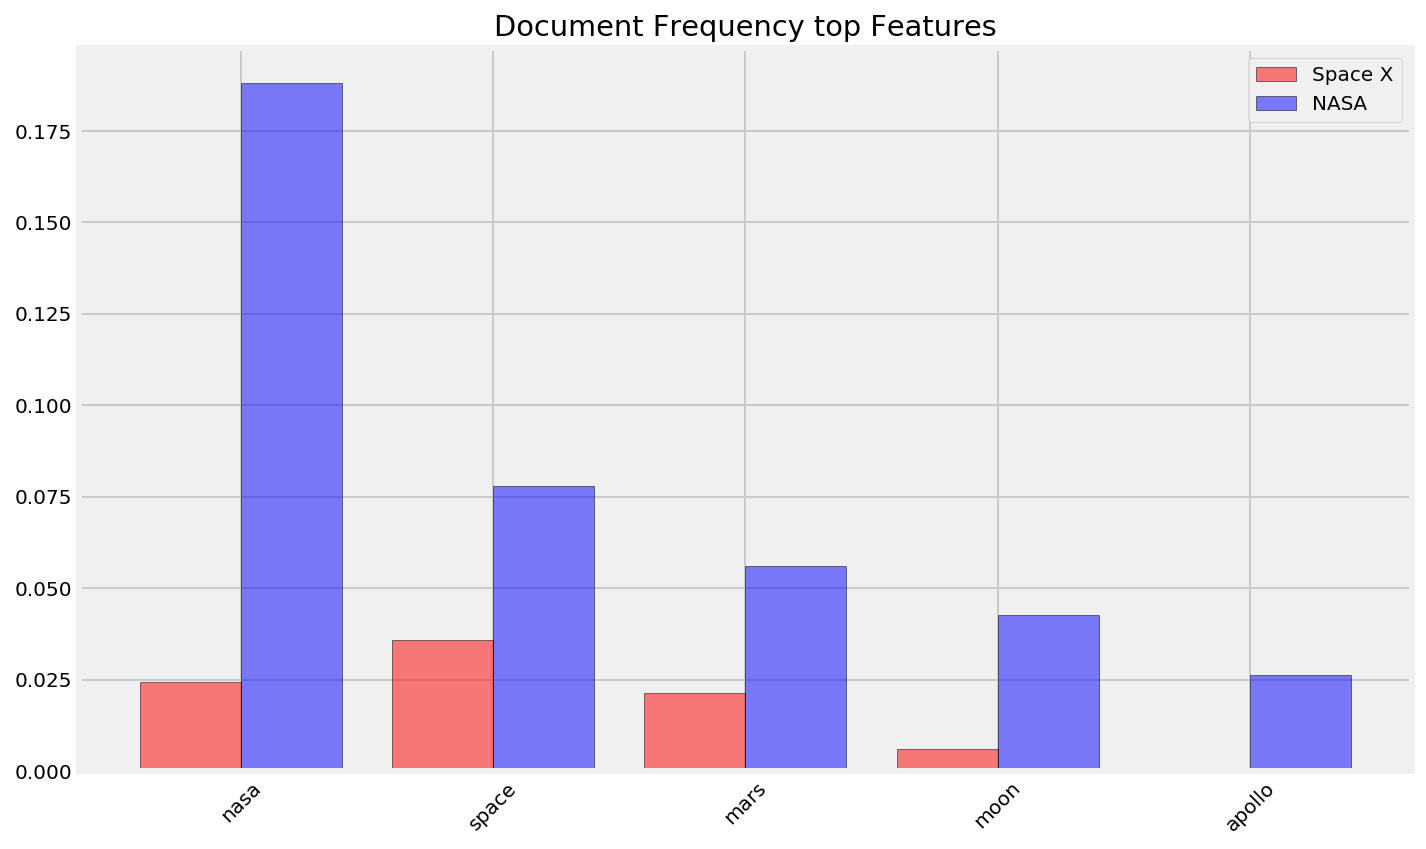

In [64]:
plt.figure(figsize=(10,6))
locs, labels = plt.xticks(fontsize=10)
plt.setp(labels, rotation=45)
plt.title('Document Frequency top Features')
plt.bar(tvec_nasa_mean_df.index, tvec_nasa_mean_df[['spacex']].T.values[0], alpha=0.5, align='edge', width=-.4, ec='k', color='red')
plt.bar(tvec_nasa_mean_df.index, tvec_nasa_mean_df[['nasa']].T.values[0], alpha=0.5, align='edge', width=.4, ec='k', color='blue')
plt.legend(['Space X', 'NASA'])
plt.tight_layout();

#### Saved Files

In [49]:
cvec_df.to_csv('../data/cvec_df.csv')
tvec_df.to_csv('../data/tvec_df.csv')